In [1]:
from keras.layers import Input, Dense, Activation, Cropping2D, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Concatenate, Add
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, UpSampling2D
from keras.models import Model
from keras.utils import layer_utils, plot_model, to_categorical, multi_gpu_model, normalize
import keras.backend as K
from PIL import Image
import numpy as np
import keras
#import models
from matplotlib import pyplot as plt
from keras.optimizers import Adam, rmsprop
import math
from keras.callbacks import TensorBoard, ModelCheckpoint, Callback, ReduceLROnPlateau, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

#Import dataset

importdataset=np.load("Numpy arrays/images.npy")
importlabels=to_categorical(np.load("Numpy arrays/masks.npy"))

print(importdataset.shape)
print(importdataset.dtype)
print(importlabels.shape)

print('Done!')

Using TensorFlow backend.


(1029, 648, 648, 3)
uint8
(1029, 648, 648, 2)
Done!


In [2]:
xsplit=1
ysplit=1

dataset=np.zeros((importdataset.shape[0]*xsplit*ysplit,int(importdataset.shape[1]/ysplit),int(importdataset.shape[2]/xsplit),importdataset.shape[3]), dtype = 'float32')
labels=np.zeros((importlabels.shape[0]*xsplit*ysplit,int(importlabels.shape[1]/ysplit),int(importlabels.shape[2]/xsplit),importlabels.shape[3]), dtype = 'bool')


for i in range(xsplit*ysplit):
    print(i+1,'out of',xsplit*ysplit)
    dataset[i*importdataset.shape[0]:(i+1)*importdataset.shape[0],:,:,:]=importdataset[:,i%ysplit*int(importdataset.shape[1]/ysplit):(i%ysplit+1)*int(importdataset.shape[1]/ysplit),math.floor(i/ysplit)%xsplit*int(importdataset.shape[2]/xsplit):(math.floor(i/ysplit)%xsplit+1)*int(importdataset.shape[2]/xsplit),:].astype('float32')/255
    labels[i*importlabels.shape[0]:(i+1)*importlabels.shape[0],:,:,:]=importlabels[:,i%ysplit*int(importlabels.shape[1]/ysplit):(i%ysplit+1)*int(importlabels.shape[1]/ysplit),math.floor(i/ysplit)%xsplit*int(importlabels.shape[2]/xsplit):(math.floor(i/ysplit)%xsplit+1)*int(importlabels.shape[2]/xsplit),:].astype('bool')

NoOfImages=dataset.shape[0]

#x_train=dataset[:int(NoOfImages*2/3),:,:,:]
#x_test=dataset[int(NoOfImages*2/3):NoOfImages,:,:,:]
#y_train=to_categorical(labels[:int(NoOfImages*2/3),:,:])
#y_test=to_categorical(labels[int(NoOfImages*2/3):NoOfImages,:,:])
#importdataset
#importlabels
print('Done!')

1 out of 1
Done!


In [3]:
print(np.amax(dataset))
dataset=2*dataset[labels[..., 1].any(axis=((1,2)))].astype('float16')-1
labels=labels[labels[..., 1].any(axis=((1,2)))]
print(np.amax(dataset))

1.0
1.0


In [4]:
print(dataset.dtype)
print(labels.dtype)
print(dataset.shape)
print(labels.shape)
a=np.sum(labels[...,0])
b=np.sum(labels[...,1])
print(a)
print(b)
print(a/(b+a))
print(dataset[68,...])

float16
bool
(216, 648, 648, 3)
(216, 648, 648, 2)
84630342
6068922
0.9330874173356026
[[[-0.8037   -0.647    -0.459   ]
  [-0.608    -0.498    -0.349   ]
  [-0.09033  -0.0825   -0.02734 ]
  ...
  [ 0.1846    0.169     0.1611  ]
  [ 0.1377    0.1211    0.1211  ]
  [ 0.1611    0.1533    0.1533  ]]

 [[-0.796    -0.639    -0.4512  ]
  [-0.5605   -0.4668   -0.3257  ]
  [-0.04297  -0.02734   0.01172 ]
  ...
  [ 0.169     0.1533    0.1455  ]
  [ 0.1455    0.1299    0.1299  ]
  [ 0.1133    0.09766   0.10547 ]]

 [[-0.8037   -0.647    -0.459   ]
  [-0.545    -0.4434   -0.3018  ]
  [ 0.02734   0.03516   0.0664  ]
  ...
  [ 0.1611    0.1455    0.1455  ]
  [ 0.1299    0.1133    0.10547 ]
  [-0.02734  -0.01953  -0.003906]]

 ...

 [[ 0.42      0.412     0.4434  ]
  [ 0.412     0.412     0.4512  ]
  [ 0.459     0.4512    0.4824  ]
  ...
  [ 0.3486    0.3408    0.3887  ]
  [ 0.3809    0.372     0.412   ]
  [ 0.4043    0.3965    0.4355  ]]

 [[ 0.459     0.459     0.4902  ]
  [ 0.412     0.412     0

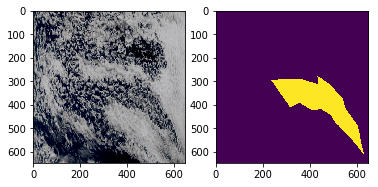

In [5]:
#sanity check

f = plt.figure()
image=109
f.add_subplot(1,2, 1)
plt.imshow(dataset[image,:,:,:].astype('float32')/2+[.5])
f.add_subplot(1,2, 2)
plt.imshow(labels[image,:,:,1])
plt.show(block=True)

In [6]:
#Resunet with variable parameter number

K.set_image_data_format('channels_last')
K.set_floatx('float32')
smallest_layer=64

def RESUNET(input_shape, n_classes):

    inputs = Input(input_shape)

    ###encoding block 1
    iden1 = Conv2D(smallest_layer, 1, activation = None, padding='same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(smallest_layer, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(inputs) #200
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Conv2D(smallest_layer, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv1) #200
    add1 = Add()([iden1,conv1])
    pool1 = MaxPooling2D()(add1) #200 -> 100
    print(add1)

    ###encoding block2
    iden2 = Conv2D(smallest_layer*2, 1, activation = None, padding='same', kernel_initializer = 'he_normal')(pool1)
    conv2 = BatchNormalization()(pool1)
    conv2 = Activation('relu')(conv2)
    conv2 = Conv2D(smallest_layer*2, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv2) #200
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    conv2 = Conv2D(smallest_layer*2, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv2) #200
    add2 = Add()([iden2,conv2])
    pool2 = MaxPooling2D()(add2) #100 ->50
    print (add2)

    ###encoding block3
    iden3 = Conv2D(smallest_layer*4, 1, activation = None, padding='same', kernel_initializer = 'he_normal')(pool2)
    conv3 = BatchNormalization()(pool2)
    conv3 = Activation('relu')(conv3)
    conv3 = Conv2D(smallest_layer*4, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv3) #200
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    conv3 = Conv2D(smallest_layer*4, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv3) #200
    add3 = Add()([iden3,conv3])
    pool3= MaxPooling2D()(add3) #50->25
    print (add3)

    ###encoding block4
    iden4 = Conv2D(smallest_layer*8, 1, activation=None, padding='same', kernel_initializer = 'he_normal')(pool3)
    conv4 = BatchNormalization()(pool3)
    conv4 = Activation('relu')(conv4)
    conv4 = Conv2D(smallest_layer*8, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv4) #200
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    conv4 = Conv2D(smallest_layer*8, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv4) #200
    add4 = Add()([iden4,conv4])
    drop4 = Dropout(0.5)(add4)
    pool4 = MaxPooling2D()(drop4) #25->12
    print (pool4)

    ###bridge
    conv5 = BatchNormalization()(pool4)
    conv5 = Activation('relu')(conv5)
    conv5 = Conv2D(smallest_layer*16, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv5) #200
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation('relu')(conv5)
    conv5 = Conv2D(smallest_layer*16, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv5) #200
    drop5 = Dropout(0.5)(conv5)
    print (conv5)

    ###decoding block1
    up6 = UpSampling2D()(drop5) #12->24
    up6 = ZeroPadding2D(((1,0),(1,0)))(up6) #24->25
    concat6 = Concatenate(axis=3)([up6,add4])
    iden6 = Conv2D(smallest_layer*8, 1, activation=None, padding='same', kernel_initializer = 'he_normal')(concat6)
    conv6 = BatchNormalization()(concat6)
    conv6 = Activation('relu')(conv6)
    conv6 = Conv2D(smallest_layer*8, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv6) #200
    conv6 = BatchNormalization()(conv6)
    conv6 = Activation('relu')(conv6)
    conv6 = Conv2D(smallest_layer*8, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv6) #200
    add6 = Add()([iden6,conv6])

    ###decoding block2
    up7 = UpSampling2D()(add6) #25->50
    up7 = ZeroPadding2D(((0,0),(0,0)))(up7) #24->25
    concat7 = Concatenate(axis=3)([up7,add3])
    iden7 = Conv2D(smallest_layer*4, 1, activation=None, padding='same', kernel_initializer = 'he_normal')(concat7)
    conv7 = BatchNormalization()(concat7)
    conv7 = Activation('relu')(conv7)
    conv7 = Conv2D(smallest_layer*4, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv7) #200
    conv7 = BatchNormalization()(conv7)
    conv7 = Activation('relu')(conv7)
    conv7 = Conv2D(smallest_layer*4, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv7) #200
    add7 = Add()([iden7,conv7])

    ###decoding block3
    up8 = UpSampling2D()(add7) #50->100
    up8 = ZeroPadding2D(((0,0),(0,0)))(up8) #24->25
    concat8 = Concatenate(axis=3)([up8,add2])
    iden8 = Conv2D(smallest_layer*2, 1, activation=None, padding='same', kernel_initializer = 'he_normal')(concat8)
    conv8 = BatchNormalization()(concat8)
    conv8 = Activation('relu')(conv8)
    conv8 = Conv2D(smallest_layer*2, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv8) #200
    conv8 = BatchNormalization()(conv8)
    conv8 = Activation('relu')(conv8)
    conv8 = Conv2D(smallest_layer*2, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv8) #200
    add8 = Add()([iden8,conv8])

    ###decoding block4
    up9 = UpSampling2D()(add8) #100->200
    up9 = ZeroPadding2D(((0,0),(0,0)))(up9) #24->25
    concat9 = Concatenate(axis=3)([up9,add1])
    iden9 = Conv2D(smallest_layer,1,activation=None, padding='same', kernel_initializer = 'he_normal')(concat9)
    conv9 = BatchNormalization()(concat9)
    conv9 = Activation('relu')(conv9)
    conv9 = Conv2D(smallest_layer, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv9) #200
    conv9 = BatchNormalization()(conv9)
    conv9 = Activation('relu')(conv9)
    conv9 = Conv2D(smallest_layer, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv9) #200
    add9 = Add()([iden9,conv9])

    conv10 = Conv2D(n_classes, 3, activation ='sigmoid', padding = 'same', kernel_initializer = 'he_normal')(add9)
    #sigmoid probably too strong an activation

    model = Model(input = inputs, output = conv10)

    return model


In [7]:
K.set_image_data_format('channels_last')
K.set_floatx('float32')
smallest_layer=32

def RESUNETMEDIUM(input_shape, n_classes):

    inputs = Input(input_shape)

    ###encoding block 1
    iden1 = Conv2D(smallest_layer, 1, activation = None, padding='same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(smallest_layer, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(inputs) #200
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Conv2D(smallest_layer, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv1) #200
    add1 = Add()([iden1,conv1])
    pool1 = MaxPooling2D((3,3))(add1) #648 -> 216
    print(add1)

    ###encoding block2
    iden2 = Conv2D(smallest_layer*2, 1, activation = None, padding='same', kernel_initializer = 'he_normal')(pool1)
    conv2 = BatchNormalization()(pool1)
    conv2 = Activation('relu')(conv2)
    conv2 = Conv2D(smallest_layer*2, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv2) #200
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    conv2 = Conv2D(smallest_layer*2, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv2) #200
    add2 = Add()([iden2,conv2])
    pool2 = MaxPooling2D((3,3))(add2) #216 -> 72
    print (add2)

    ###encoding block4
    iden4 = Conv2D(smallest_layer*8, 1, activation=None, padding='same', kernel_initializer = 'he_normal')(pool2)
    conv4 = BatchNormalization()(pool2)
    conv4 = Activation('relu')(conv4)
    conv4 = Conv2D(smallest_layer*8, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv4) #200
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    conv4 = Conv2D(smallest_layer*8, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv4) #200
    add4 = Add()([iden4,conv4])
    drop4 = Dropout(0.5)(add4)
    pool4 = MaxPooling2D((3,3))(drop4) #72 -> 24
    print (pool4)

    ###bridge
    conv5 = BatchNormalization()(pool4)
    conv5 = Activation('relu')(conv5)
    conv5 = Conv2D(smallest_layer*16, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv5) #200
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation('relu')(conv5)
    conv5 = Conv2D(smallest_layer*16, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv5) #200
    drop5 = Dropout(0.5)(conv5)
    print (conv5)

    ###decoding block1
    up6 = UpSampling2D((3,3))(drop5) #24->72
    #up6 = ZeroPadding2D(((1,0),(1,0)))(up6) #24->25
    concat6 = Concatenate(axis=3)([up6,add4])
    iden6 = Conv2D(smallest_layer*8, 1, activation=None, padding='same', kernel_initializer = 'he_normal')(concat6)
    conv6 = BatchNormalization()(concat6)
    conv6 = Activation('relu')(conv6)
    conv6 = Conv2D(smallest_layer*8, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv6) #200
    conv6 = BatchNormalization()(conv6)
    conv6 = Activation('relu')(conv6)
    conv6 = Conv2D(smallest_layer*8, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv6) #200
    add6 = Add()([iden6,conv6])

    ###decoding block3
    up8 = UpSampling2D((3,3))(add6) #72 -> 216
    up8 = ZeroPadding2D(((0,0),(0,0)))(up8) #24->25
    concat8 = Concatenate(axis=3)([up8,add2])
    iden8 = Conv2D(smallest_layer*2, 1, activation=None, padding='same', kernel_initializer = 'he_normal')(concat8)
    conv8 = BatchNormalization()(concat8)
    conv8 = Activation('relu')(conv8)
    conv8 = Conv2D(smallest_layer*2, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv8) #200
    conv8 = BatchNormalization()(conv8)
    conv8 = Activation('relu')(conv8)
    conv8 = Conv2D(smallest_layer*2, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv8) #200
    add8 = Add()([iden8,conv8])

    ###decoding block4
    up9 = UpSampling2D((3,3))(add8) #216 -> 648
    up9 = ZeroPadding2D(((0,0),(0,0)))(up9) #24->25
    concat9 = Concatenate(axis=3)([up9,add1])
    iden9 = Conv2D(smallest_layer,1,activation=None, padding='same', kernel_initializer = 'he_normal')(concat9)
    conv9 = BatchNormalization()(concat9)
    conv9 = Activation('relu')(conv9)
    conv9 = Conv2D(smallest_layer, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv9) #200
    conv9 = BatchNormalization()(conv9)
    conv9 = Activation('relu')(conv9)
    conv9 = Conv2D(smallest_layer, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv9) #200
    add9 = Add()([iden9,conv9])

    conv10 = Conv2D(n_classes, 3, activation ='sigmoid', padding = 'same', kernel_initializer = 'he_normal')(add9)
    #sigmoid probably too strong an activation

    model = Model(input = inputs, output = conv10)

    return model


In [8]:
K.set_image_data_format('channels_last')
K.set_floatx('float32')
smallest_layer=42

def RESUNETSMALL(input_shape, n_classes):
    inputs = Input(input_shape)

    ###encoding block 1
    iden1 = Conv2D(smallest_layer, 1, activation = None, padding='same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(smallest_layer, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(inputs) #200
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Conv2D(smallest_layer, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv1) #200
    add1 = Add()([iden1,conv1])
    pool1 = MaxPooling2D((4,4))(add1) #648 -> 162
    print(add1)

    ###encoding block3
    iden3 = Conv2D(smallest_layer*4, 1, activation = None, padding='same', kernel_initializer = 'he_normal')(pool1)
    conv3 = BatchNormalization()(pool1)
    conv3 = Activation('relu')(conv3)
    conv3 = Conv2D(smallest_layer*4, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv3) #200
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    conv3 = Conv2D(smallest_layer*4, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv3) #200
    add3 = Add()([iden3,conv3])
    #drop3 = Dropout(0.5)(add3)
    pool3= MaxPooling2D((4,4))(add3)#(drop3) #162 -> 40
    print (add3)

    ###bridge
    conv5 = BatchNormalization()(pool3)
    conv5 = Activation('relu')(conv5)
    conv5 = Conv2D(smallest_layer*16, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv5) #200
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation('relu')(conv5)
    conv5 = Conv2D(smallest_layer*16, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv5) #200
    drop5 = Dropout(0.5)(conv5)
    print (conv5)

    ###decoding block2
    up7 = UpSampling2D((4,4))(drop5) #40-> 160
    up7 = ZeroPadding2D(((0,2),(0,2)))(up7) #160->162
    concat7 = Concatenate(axis=3)([up7,add3])
    iden7 = Conv2D(smallest_layer*4, 1, activation=None, padding='same', kernel_initializer = 'he_normal')(concat7)
    conv7 = BatchNormalization()(concat7)
    conv7 = Activation('relu')(conv7)
    conv7 = Conv2D(smallest_layer*4, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv7) #200
    conv7 = BatchNormalization()(conv7)
    conv7 = Activation('relu')(conv7)
    conv7 = Conv2D(smallest_layer*4, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv7) #200
    add7 = Add()([iden7,conv7])

    ###decoding block4
    up9 = UpSampling2D((4,4))(add7) #162->648
    up9 = ZeroPadding2D(((0,0),(0,0)))(up9) #24->25
    concat9 = Concatenate(axis=3)([up9,add1])
    iden9 = Conv2D(smallest_layer,1,activation=None, padding='same', kernel_initializer = 'he_normal')(concat9)
    conv9 = BatchNormalization()(concat9)
    conv9 = Activation('relu')(conv9)
    conv9 = Conv2D(smallest_layer, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv9) #200
    conv9 = BatchNormalization()(conv9)
    conv9 = Activation('relu')(conv9)
    conv9 = Conv2D(smallest_layer, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv9) #200
    add9 = Add()([iden9,conv9])

    conv10 = Conv2D(n_classes, 3, activation ='sigmoid', padding = 'same', kernel_initializer = 'he_normal')(add9)
    #sigmoid probably too strong an activation

    model = Model(input = inputs, output = conv10)

    return model

In [9]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)


In [10]:
"""
A weighted version of categorical_crossentropy for keras (2.0.6). This lets you apply a weight to unbalanced classes.
@url: https://gist.github.com/wassname/ce364fddfc8a025bfab4348cf5de852d
@author: wassname
"""
from keras import backend as K
def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss


In [11]:
def create_weighted_binary_crossentropy(zero_weight, one_weight):

    def weighted_binary_crossentropy(y_true, y_pred):

        # Original binary crossentropy (see losses.py):
        # K.mean(K.binary_crossentropy(y_true, y_pred), axis=-1)

        # Calculate the binary crossentropy
        b_ce = K.binary_crossentropy(y_true, y_pred)

        # Apply the weights
        weight_vector = y_true * one_weight + (1. - y_true) * zero_weight
        weighted_b_ce = weight_vector * b_ce

        # Return the mean error
        return K.mean(weighted_b_ce)

    return weighted_binary_crossentropy

In [12]:
def jaccard_distance(y_true, y_pred, smooth=100):
    """Jaccard distance for semantic segmentation.
    Also known as the intersection-over-union loss.
    This loss is useful when you have unbalanced numbers of pixels within an image
    because it gives all classes equal weight. However, it is not the defacto
    standard for image segmentation.
    For example, assume you are trying to predict if
    each pixel is cat, dog, or background.
    You have 80% background pixels, 10% dog, and 10% cat.
    If the model predicts 100% background
    should it be be 80% right (as with categorical cross entropy)
    or 30% (with this loss)?
    The loss has been modified to have a smooth gradient as it converges on zero.
    This has been shifted so it converges on 0 and is smoothed to avoid exploding
    or disappearing gradient.
    Jaccard = (|X & Y|)/ (|X|+ |Y| - |X & Y|)
            = sum(|A*B|)/(sum(|A|)+sum(|B|)-sum(|A*B|))
    # Arguments
        y_true: The ground truth tensor.
        y_pred: The predicted tensor
        smooth: Smoothing factor. Default is 100.
    # Returns
        The Jaccard distance between the two tensors.
    # References
        - [What is a good evaluation measure for semantic segmentation?](
           http://www.bmva.org/bmvc/2013/Papers/paper0032/paper0032.pdf)
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

(764, 648, 648, 1)
(764, 648, 648, 1)


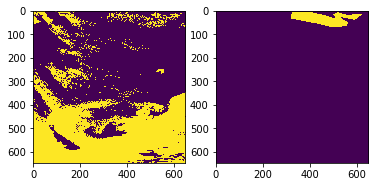

In [13]:
#only need 1 dimension for labels. reserve 25 images as a test set
labelstemp=labels[:-25,...,1].reshape([labels.shape[0]-25,648,648,1])
datasettemp=dataset[:-25,...].reshape([labels.shape[0]-25,648,648,3])
#labelstemp=np.sum(datasettemp, axis=3) <= np.mean(np.sum(datasettemp, axis=3), axis=(1,2))[:,None,None]/2
#labelstemp=labelstemp.reshape([labels.shape[0]-25,648,648,1])
datasettemp=np.sum(datasettemp, axis=3) <= np.mean(np.sum(datasettemp, axis=3), axis=(1,2))[:,None,None]/2
datasettemp=datasettemp.reshape([labels.shape[0]-25,648,648,1])
#add all 4 rotations of 90 degrees to augment data
labelstrain=np.copy(labelstemp)
datasettrain=np.copy(datasettemp)
for i in range(3):
    labelstrain=np.append(labelstrain, np.rot90(labelstemp, k=i+1, axes=(1,2)), axis=0)
    datasettrain=np.append(datasettrain, np.rot90(datasettemp, k=i+1, axes=(1,2)), axis=0)

print(datasettrain.shape)
print(labelstrain.shape)
f = plt.figure()
image=573
f.add_subplot(1,2, 1)
plt.imshow(datasettrain[image,:,:,0].astype('float32')/2+[.5])
f.add_subplot(1,2, 2)
plt.imshow(labelstrain[image,:,:,0])
plt.show(block=True)

In [14]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0,1,2,3,4,5,6,7,8"
no_gpus=8
smallest_layer=42
if no_gpus > 1:
    model=multi_gpu_model(RESUNET(datasettrain.shape[1:],1), gpus=no_gpus)
#model=RESUNET(dataset.shape[1:],2)
else:
    model=RESUNET(datasettrain.shape[1:],1)
#model=multi_gpu_model(model,gpus=8)

from keras.metrics import categorical_accuracy
optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
#optimizer=rmsprop(lr=0.0001)
#loss=create_weighted_binary_crossentropy(0.01,0.99)
#loss=jaccard_distance
loss=dice_coef_loss
model.compile(optimizer=optimizer,
                         loss=loss, metrics=[dice_coef, 'accuracy', 'binary_crossentropy'])
print(model.summary())
#plot_model(model, to_file='model.png')

Tensor("add_1/add:0", shape=(?, 648, 648, 42), dtype=float32)
Tensor("add_2/add:0", shape=(?, 324, 324, 84), dtype=float32)
Tensor("add_3/add:0", shape=(?, 162, 162, 168), dtype=float32)
Tensor("max_pooling2d_4/MaxPool:0", shape=(?, 40, 40, 336), dtype=float32)
Tensor("conv2d_14/BiasAdd:0", shape=(?, 40, 40, 672), dtype=float32)


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:123: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 648, 648, 1)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 648, 648, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 648, 648, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 648, 648, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_4 (

In [ ]:
#model.fit(x_train, y_train, batch_size=100, epochs=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1,) #min_lr=5e-7, verbose=1)
#earlystopper = EarlyStopping(patience=8, verbose=1)
checkpointer = ModelCheckpoint(filepath='Checkpoint_Weights.h5', save_best_only=True)

batch_size=2*no_gpus
history = model.fit(datasettrain, labelstrain, batch_size=batch_size, epochs=80, callbacks=[reduce_lr, checkpointer], validation_split=0.2)
#score = model.evaluate(x_test, y_test, batch_size=5)

Train on 611 samples, validate on 153 samples
Epoch 1/80
611/611 [==============================] - 85s 139ms/step - loss: 0.5321 - dice_coef: 0.4679 - acc: 0.9250 - binary_crossentropy: 1.1957 - val_loss: 0.7871 - val_dice_coef: 0.2129 - val_acc: 0.5568 - val_binary_crossentropy: 6.8612
Epoch 2/80
611/611 [==============================] - 86s 141ms/step - loss: 0.5361 - dice_coef: 0.4639 - acc: 0.9282 - binary_crossentropy: 1.1449 - val_loss: 0.7847 - val_dice_coef: 0.2153 - val_acc: 0.6115 - val_binary_crossentropy: 5.8047
Epoch 3/80
611/611 [==============================] - 85s 139ms/step - loss: 0.5255 - dice_coef: 0.4745 - acc: 0.9238 - binary_crossentropy: 1.2158 - val_loss: 0.7845 - val_dice_coef: 0.2155 - val_acc: 0.5746 - val_binary_crossentropy: 6.5918
Epoch 4/80
611/611 [==============================] - 86s 141ms/step - loss: 0.5197 - dice_coef: 0.4803 - acc: 0.9268 - binary_crossentropy: 1.1671 - val_loss: 0.7826 - val_dice_coef: 0.2174 - val_acc: 0.5850 - val_binary_cro

In [23]:
def shuffle_in_unison(a, b):
    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b

datasettrain, labelstrain=shuffle_in_unison(datasettrain,labelstrain)
print(datasettrain.shape[0])
print(labelstrain.shape[0])

764
764


In [22]:
from keras.models import load_model
import keras.losses
import keras.metrics

keras.losses.dice_coef_loss = dice_coef_loss
keras.metrics.dice_coef = dice_coef
model = load_model('resunet_train_inverted_image_poc_trained.h5')


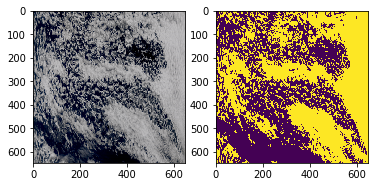

In [16]:
f = plt.figure()
image=109
f.add_subplot(1,2, 1)
plt.imshow(datasettrain[image,:,:,:].astype('float32')/2+[.5])
f.add_subplot(1,2, 2)
plt.imshow(labelstrain[image,:,:,0])
plt.show(block=True)

In [42]:
batch_size_per_gpu=2
batch_size=batch_size_per_gpu*no_gpus
validation_split=0.2


datagen = ImageDataGenerator(
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    validation_split=validation_split)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=5e-9, verbose=1)
earlystopper = EarlyStopping(patience=8, verbose=1)

if no_gpus == 1:
    history = model.fit_generator(datagen.flow(datasettrain, labelstrain, batch_size=batch_size, subset='training'),
                    epochs=100, callbacks=[reduce_lr], steps_per_epoch=dataset.shape[0]*(1-validation_split)//batch_size, 
                    validation_data=datagen.flow(datasettrain, labelstrain, batch_size=batch_size, subset='validation'),
                    validation_steps=dataset.shape[0]*validation_split//batch_size,)#, use_multiprocessing=True)
else:
    history = model.fit_generator(datagen.flow(datasettrain, labelstrain, batch_size=batch_size, subset='training'),
                    epochs=100, callbacks=[reduce_lr], steps_per_epoch=dataset.shape[0]*(1-validation_split)//batch_size, 
                    validation_data=datagen.flow(datasettrain, labelstrain, batch_size=batch_size_per_gpu, subset='validation'),
                    validation_steps=dataset.shape[0]*validation_split//batch_size_per_gpu, use_multiprocessing=True)

Epoch 1/100


Process ForkPoolWorker-24:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
Process ForkPoolWorker-25:
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/ubuntu/anaconda3/envs/tensorf

KeyboardInterrupt: 

Process ForkPoolWorker-30:
Process ForkPoolWorker-28:
Process ForkPoolWorker-27:
Process ForkPoolWorker-26:
Process ForkPoolWorker-29:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  

In [23]:
epochs = np.arange(len(history.history['val_loss']))
plt.plot(epochs, history.history['loss'], label='loss')
plt.plot(epochs, history.history['val_loss'], label='val_loss')
plt.plot(epochs, history.history['dice_coef'], label='dice_coef')
plt.plot(epochs, history.history['val_dice_coef'], label='val_dice_coef')
plt.plot(epochs, history.history['acc'], label='accuracy')
plt.plot(epochs, history.history['val_acc'], label='val_accuracy')
plt.legend(loc='upper left')
plt.show()
print(model.summary())



NameError: name 'history' is not defined

In [73]:
plot_model(model, to_file='model.png')

ImportError: Failed to import `pydot`. Please install `pydot`. For example with `pip install pydot`.

In [17]:
model.save("resunet_train_inverted_image_poc_trained.h5")

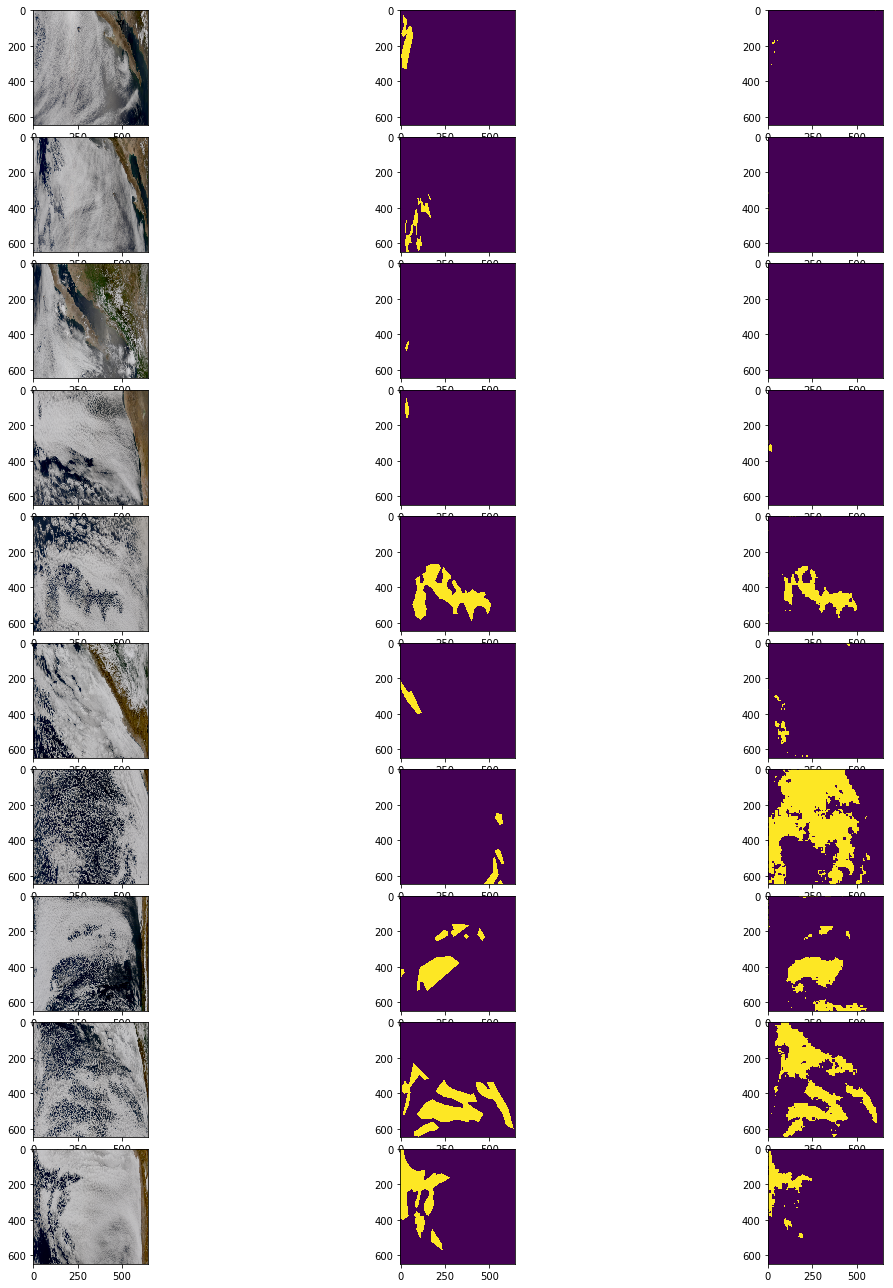

In [26]:
f = plt.figure(figsize=(18,18))
samples=datasettrain[0:200:20,:,:,:].astype('float32')
annotations=labelstrain[0:200:20,:,:,0]
prediction=model.predict(samples, batch_size=2)
for image, sample in enumerate(samples):
    f.add_subplot(samples.shape[0],3, 3*image+1)
    plt.imshow(samples[image,:,:,:]/2+0.5)
    f.add_subplot(samples.shape[0],3, 3*image+2)
    plt.imshow(annotations[image,:,:])
    f.add_subplot(samples.shape[0],3, 3*image+3)
    plt.imshow(prediction[image,:,:,0])
f.tight_layout()
f.subplots_adjust(hspace=0.1)
plt.show(block=True)

In [42]:
%reset



Once deleted, variables cannot be recovered. Proceed (y/[n])? no
Nothing done.


In [64]:
labels.shape[0:3]

(216, 648, 648)

In [ ]:
from sklearn.metrics import classification_report
y_true = labelsnew.tolist()
y_pred = model.predict(dataset, batch_size=batch_size)
target_names = ['not POC', 'POC']
print(classification_report(y_true, y_pred, target_names=target_names))

In [81]:
a=np.eye(3).reshape((3,3,1))
b=np.copy(a)
for i in range(3):
    b=np.append(b, np.rot90(a, k=i+1), axis=2)
    print(i)
print(b[:,:,])
print(a[:,:,0])
print(b.shape)



0
1
2
[[0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
(3, 3, 4)
